In [1]:

root_dir = './'

import sys
sys.path.append(root_dir)
import numpy as np
import pandas as pd
import neural_tape_controller
import optimize
import pickle
from PIL import Image, ImageDraw,ImageFont
from matplotlib import pyplot as plt
#Положительные числа - положительные награды.
root = root_dir

# Описание игровых действий

In [2]:
def encode_simple_colors(X):
  #как сделать простое кодирование? Ну давай разобьём картинку тремя разными сетками и измерим яркость
  #на входе одиночная картинка
  y_lst = []
  sz = np.shape(X)
  for color_channel in range(3):
    count_squares = 10
    for i in range(count_squares):
      for j in range(count_squares):
        x = X[int(i*sz[0]/count_squares):int((i+1)*sz[0]/count_squares), int(j*sz[1]/count_squares):int((j+1)*sz[1]/count_squares),color_channel]
        y_lst.append(np.nanmean(x))

    count_squares = 7
    for i in range(count_squares):
      for j in range(count_squares):
        x = X[int(i*sz[0]/count_squares):int((i+1)*sz[0]/count_squares), int(j*sz[1]/count_squares):int((j+1)*sz[1]/count_squares),color_channel]
        y_lst.append(np.nanmean(x))

    count_squares = 3
    for i in range(count_squares):
      for j in range(count_squares):
        x = X[int(i*sz[0]/count_squares):int((i+1)*sz[0]/count_squares), int(j*sz[1]/count_squares):int((j+1)*sz[1]/count_squares),color_channel]
        y_lst.append(np.nanmean(x))

  #размер: 474(10**2 + 7**2 + 3**2)*3
  return np.array(y_lst)

In [3]:
def white_to_transparency(img):
    x = np.asarray(img.convert('RGBA')).copy()
    x[:, :, 3] = (255 * (x[:, :, :3] != 255).any(axis=2)).astype(np.uint8)
    return Image.fromarray(x)
class strat_game():
  def __init__(self):
    self.field = np.round((np.random.rand(48,48)**150)*12)
    self.money = [50,50]
    self.units = []
    #unit: type,hp,maxhp,cooldown,t,team,resourse,dv,r,armour_type, att_range, att_type, vx,vy,x,y, target
    self.unit_db = {}
    #armour_type: inf, cavalry, heavy_inf
    #att_type: miner, pike, arrow, sword, heal
    unit_type = {'type':'worker','maxhp':1,'cooldown':2,'armour_type':'inf', 'att_type':'miner', 'r':0.1,'dv':0.9,'att_range':1,'price':7}
    self.unit_db['worker']=unit_type
    unit_type = {'type':'pikeman','maxhp':2,'cooldown':5,'armour_type':'inf', 'att_type':'pike', 'r':0.1,'dv':0.9,'att_range':4,'price':5}
    self.unit_db['pikeman']=unit_type
    unit_type = {'type':'swordsman','maxhp':2,'cooldown':4,'armour_type':'heavy_inf', 'att_type':'sword', 'r':0.1,'dv':0.7,'att_range':1,'price':7}
    self.unit_db['swordsman']=unit_type
    unit_type = {'type':'archer','maxhp':1.5,'cooldown':14,'armour_type':'inf','att_type':'arrow', 'r':0.1,'dv':0.9,'att_range':15,'price':7}
    self.unit_db['archer']=unit_type
    unit_type = {'type':'medic','maxhp':1.6,'cooldown':12,'armour_type':'inf','att_type':'heal', 'r':0.1,'dv':1.1,'att_range':1,'price':7}
    self.unit_db['medic']=unit_type
    unit_type = {'type':'knight','maxhp':4,'cooldown':2,'armour_type':'cavalry','att_type':'sword', 'r':0.3,'dv':1.9,'att_range':1.3,'price':16}
    self.unit_db['knight']=unit_type

    self.sprite_base = {}

    if 0:
      self.add_unit('pikeman',(1,10),0)
      self.add_unit('pikeman',(1,20),0)
      self.add_unit('medic',(1,30),0)
      self.add_unit('archer',(1,40),0)
      self.add_unit('swordsman',(1,45),0)
      self.add_unit('knight',(1,35),0)

      self.add_unit('worker',(40,10),1)
      self.add_unit('worker',(40,20),1)
      self.add_unit('medic',(40,30),1)
      self.add_unit('archer',(40,40),1)
      self.add_unit('swordsman',(40,45),1)
      self.add_unit('knight',(40,35),1)
  def get_sprite(self,sprite_name):
    if not(sprite_name in self.sprite_base.keys()):
      self.sprite_base[sprite_name] = Image.open(root+'sprites/'+sprite_name+'.bmp')#загрузить картинку. Это bmp, пиксель-арт. Белые точки игнорировать
      self.sprite_base[sprite_name] = white_to_transparency(self.sprite_base[sprite_name])
    return self.sprite_base[sprite_name]

  def add_unit(self,unit_type,coords,team):
    unit = {}
    unit['id'] = len(self.units)
    unit['x'],unit['y']=coords
    for key in self.unit_db[unit_type].keys():
      unit[key]=self.unit_db[unit_type][key]
    unit['hp']=unit['maxhp']
    unit['t']=0
    unit['target']=None
    unit['team']=team
    self.units.append(unit)
  def step_env(self,draw=False):
    if 1:
        scale = 6
        #нарисовать землю
        im = Image.new('RGB', (np.shape(self.field)[0]*scale, np.shape(self.field)[1]*scale), (0, 64, 0))
        dr = ImageDraw.Draw(im)
        #нарисовать золото
        for x in range(np.shape(self.field)[0]):
          for y in range(np.shape(self.field)[1]):
            if self.field[x,y]>0:
              if self.field[x,y]<2:
                color = "green"
              elif self.field[x,y]<4:
                color = "lime"
              elif self.field[x,y]<7:
                color = "gold"
              else:
                color = "yellow"
              shape = [((x-0.5)*scale, (y-0.5)*scale), ((x+0.5)*scale, (y+0.5)*scale)]
              dr.rectangle(shape, fill=color)
              sprite = self.get_sprite("gold")
              sprite = sprite.resize((scale,scale))
              im.paste(sprite,(int((x-0.5)*scale),int((y-0.5)*scale)),sprite.split()[-1])

    #ходят юниты
    for unit_num in range(len(self.units)):
      unit = self.units[unit_num]
      if unit['hp']>0:
        if 1:
          #нарисовать юнита
          shape = [((unit['x']-0.5)*scale, (unit['y']-0.5)*scale), ((unit['x']+0.5)*scale, (unit['y']+0)*scale)]
          if unit['team']==0:
            team_color = 'red'
          else:
            team_color = 'blue'
          dr.rectangle(shape, fill=team_color)
          sprite = self.get_sprite(unit['type'])
          if unit['team']==1:
            sprite =  sprite.transpose(Image.FLIP_LEFT_RIGHT)
          im.paste(sprite,(int(unit['x']*scale),int(unit['y']*scale)),sprite.split()[-1])

        unit['t']+=1
        #вначале каждый обновляет себе цель. Это затратно, так что пусть будет вероятностно
        if (np.random.rand()<0.3) or not ('tgt' in unit.keys()):
          team = unit['team']
          if unit['att_type']!='miner':
            unit['trg'] = None
            close_dist = 1e10
            for unit_trg_num in range(len(self.units)):
              unit_trg = self.units[unit_trg_num]
              if (unit_trg['hp']>0):
                if ((unit['att_type']=='heal') and (unit_trg['team']==team) and (unit_trg['hp']<unit_trg['maxhp']))  or  ((unit['att_type']!='heal') and (unit_trg['team']!=team)):
                  dist = np.abs(unit_trg['x']-unit['x'])+np.abs(unit_trg['y']-unit['y'])
                  if dist<close_dist:
                    close_dist=dist
                    unit['trg'] = unit_trg_num
                    unit['trg_x'] = unit_trg['x']
                    unit['trg_y'] = unit_trg['y']
          else:
            trg_x=-1
            trg_y=-1
            for radius in range(np.shape(self.field)[0]):
              x_min = int(np.max([0,unit['x']-radius]))
              x_max = int(np.min([np.shape(self.field)[0],unit['x']+radius]))
              y_min = int(np.max([0,unit['y']-radius]))
              y_max = int(np.min([np.shape(self.field)[0],unit['y']+radius]))
              for x in range(x_min,x_max):
                for y in [y_min,y_max-1]:
                  if self.field[x,y]>0:
                    #нашёл
                    trg_x = x
                    trg_y = y
                    break
                if trg_x>=0:
                    break
              if trg_x>=0:
                break
              for y in range(y_min,y_max):
                for x in [x_min,x_max-1]:
                  if self.field[x,y]>0:
                    #нашёл
                    trg_x = x
                    trg_y = y
                    break
                if trg_x>=0:
                    break
            unit['trg'] = -1
            unit['trg_x'] = trg_x
            unit['trg_y'] = trg_y
      if unit['hp']>0:
          #затем делают шаг в сторону цели, если дистанция недостаточна для атаки
          if not (unit['trg']) is None:
            if unit['trg']!=-1:#рабочий
              unit['trg_x'] = self.units[unit['trg']]['x']
              unit['trg_y'] = self.units[unit['trg']]['y']
            dx = unit['trg_x']-unit['x']
            dy = unit['trg_y']-unit['y']
            dist = np.abs(dx)+np.abs(dy)
            if dist>unit['att_range']:
              if dist>unit['dv']:
                dx/=dist
                dy/=dist
                dx*=unit['dv']
                dy*=unit['dv']
              else:
                dx/=dist
                dy/=dist
                dx*=unit['dv']/2
                dy*=unit['dv']/2
              #делают шаг, если поле не блокировано
              locked = False
              for unit_locker in self.units:
                if (unit_locker['hp']>0) and (unit_locker['id']!=unit['id']):
                  dist_locker = np.abs(unit_locker['x']-unit['x']-dx)+np.abs(unit_locker['y']-unit['y']-dy)
                  if dist_locker<unit['r']+unit_locker['r']:
                    locked=True
                    break
              if not locked:
                unit['x']+=dx
                unit['y']+=dy
            else:
              #иначе атакуют
              if unit['t']>=unit['cooldown']:
                unit['t']=0
                if unit['att_type']=='miner':
                  gain = np.min([2,self.field[unit['trg_x'],unit['trg_y']]])
                  self.field[unit['trg_x'],unit['trg_y']]-=gain
                  self.money[unit['team']]+=gain
                elif unit['att_type']=='heal':
                  self.units[unit['trg']]['hp'] = self.units[unit['trg']]['maxhp']
                else:
                  #обычная атака
                  armour = self.units[unit['trg']]['armour_type']
                  att_type = unit['att_type']
                  coef = 1
                  if (armour=='cavalry') and (att_type=='arrow'):
                    coef=0.2
                  elif (armour=='cavalry') and (att_type=='pike'):
                    coef = 5
                  elif (armour=='heavy_inf') and ((att_type=='pike') or (att_type=='arrow')):
                    coef=0.4
                  self.units[unit['trg']]['hp']-=coef

                  if att_type=='arrow':
                    #нарисовать стрелу
                    x_start = unit['x']*scale
                    y_start = unit['y']*scale
                    x_end = unit['trg_x']*scale
                    y_end = unit['trg_y']*scale
                    arr_len = scale*1.5
                    x_start = (x_start+x_end)/2
                    y_start = (y_start+y_end)/2
                    dx = x_end-x_start
                    dy = y_end-y_start
                    dist = np.abs(dx)+np.abs(dy)
                    dx/=dist
                    dy/=dist
                    dx*=arr_len
                    dy*=arr_len
                    dr.line((x_start,y_start, x_start+dx,y_start+dy), fill="silver",width=1)

    if 1:
      #число денег
      dr.text((1, 1),f"{int(self.money[0])}",'red')
      dr.text((np.shape(self.field)[1]*scale-27,1),f"{int(self.money[1])}",'blue')
      if draw:
        im=im.resize((900,900))
        globals()['video'].append(im)
        #plt.rcParams["figure.figsize"] = (20,20)
        #plt.imshow(im)
        #plt.show()
    return im
  def action(self,team,action_vector):
    #какие вообще варианты, что делать? Нанимать юнитов, только и всего
    argm = np.argmax(action_vector[:6])#что нанимать
    units_d = ['worker','pikeman','swordsman','archer','medic','knight']
    if action_vector[argm]>0:#нанимать ли
      if self.money[team]>=self.unit_db[units_d[argm]]['price']:
        self.money[team]-=self.unit_db[units_d[argm]]['price']
        #куда? Зона найма - это поле 50 на 500
        x = np.shape(self.field)[0]/10*action_vector[6]
        y = np.shape(self.field)[0]*action_vector[7]
        if x<2:
          x=2
        if x>np.shape(self.field)[0]/10-2:
          x=np.shape(self.field)[0]/10-2
        if y<2:
          y=2
        if y>np.shape(self.field)[0]-2:
          y=np.shape(self.field)[0]-2
        if team==1:
          x = np.shape(self.field)[0]-x
        self.add_unit(units_d[argm],(x,y),team)

In [4]:
def single_game(players,seed=0,rounds=1000,draw=False):
  np.random.seed(seed)
  game = strat_game()
  for t in range(rounds):
    img = game.step_env(draw=draw)
    if t%7==0:
      #ходят игроки. По одному действию
      action_vector = players[0].act(img,game,team=0)
      game.action(0,action_vector)
      action_vector = players[1].act(img,game,team=1)
      game.action(1,action_vector)
  scores = game.money
  #за кем поле боя?
  player1_units=0
  player2_units=0
  player2_units_with_dead=0
  for unit in game.units:
    if unit['team']==1:
        player2_units_with_dead+=1
    if unit['hp']>0:
      if unit['team']==0:
        player1_units+=1
      elif unit['team']==1:
        player2_units+=1
    if (player2_units>0) and (player1_units>0):
      break

  return scores,(player1_units,player2_units),game.field,player2_units_with_dead

In [5]:
class player_only_workers():
  def __init__(self):
    self.tact = 0
  def act(self,img,game,team):
    x= np.random.rand()
    y= np.random.rand()
    if self.tact<=4:
      #рабочий
      action_vector = [1,0,0,0,0,0,x,y]
    else:
      action_vector = [0,0,0,0,0,0,0,0]
    self.tact+=1
    return action_vector
class player_few_units():
  def __init__(self):
    self.tact = 0
  def act(self,img,game,team):
    x= np.random.rand()
    y= np.random.rand()
    if self.tact<=3:
      #рабочий
      action_vector = [1,0,0,0,0,0,x,y]
    elif self.tact<=5:
      #лучник
      action_vector = [0,0,0,1,0,0,x,y]
    else:
      action_vector = [0,0,0,0,0,0,0,0]
    self.tact+=1
    return action_vector
class player_knight():
  def __init__(self):
    self.tact = 0
  def act(self,img,game,team):
    x= np.random.rand()
    y= np.random.rand()
    if self.tact==3:
      #всадник
      action_vector = [0,0,0,0,0,1,x,y]
    elif self.tact<=5:
      #рабочий
      action_vector = [1,0,0,0,0,0,x,y]
    else:
      action_vector = [0,0,0,0,0,0,0,0]
    self.tact+=1
    return action_vector

class player_many_knights():
  def __init__(self):
    self.tact = 0
  def act(self,img,game,team):
    x= np.random.rand()
    y= np.random.rand()
    if self.tact<=3:
      #всадник
      action_vector = [0,0,0,0,0,1,x,y]
    elif self.tact<=8:
      #рабочий
      action_vector = [1,0,0,0,0,0,x,y]
    else:
      action_vector = [0,0,0,0,0,0,0,0]
    self.tact+=1
    return action_vector

class player_balance():
  def __init__(self):
    pass
  def act(self,img,game,team):
    x= np.random.rand()
    y= np.random.rand()
    #если у противника перевес по юнитам, создать юнита. Если нет рабочих, создать рабочего
    our_workers = 0
    enemy_mil_units = 0
    our_mil_units = 0
    for unit in game.units:
      if unit['hp']>0:
        if unit['team']!=team:
          if (unit['type']!='worker') and (unit['type']!='medic'):
            enemy_mil_units+=1
        elif (unit['type']!='worker') and (unit['type']!='medic'):
          our_mil_units+=1
        elif unit['type']=='worker':
          our_workers+=1
    action_vector = [0,0,0,0,0,0,0,0]

    if our_workers==0:
      #рабочий
      action_vector = [1,0,0,0,0,0,x,y]
    if our_mil_units<enemy_mil_units-1:
      #стрелок
      action_vector = [0,0,1,0,0,0,x,y]
    if our_mil_units==0:
      #всадник
      action_vector = [0,0,0,0,0,1,x,y]
    return action_vector

class player_adaptive():
  def __init__(self):
    pass
  def act(self,img,game,team):
    x= np.random.rand()
    y= np.random.rand()
    #если у противника перевес по юнитам, создать юнита. Если нет рабочих, создать рабочего
    our_workers = 0
    enemy_mil_units = 0
    enemy_spear = 0
    enemy_archer = 0
    enemy_cavalry = 0
    our_mil_units = 0
    for unit in game.units:
      if unit['hp']>0:
        if unit['team']!=team:
          if (unit['type']!='worker') and (unit['type']!='medic'):
            enemy_mil_units+=1
            if unit['type']=='pikeman':
              enemy_spear+=1
            elif unit['type']=='archer':
              enemy_archer+=1
            elif unit['type']=='knight':
              enemy_cavalry+=2
        elif (unit['type']!='worker') and (unit['type']!='medic'):
          our_mil_units+=1
        elif unit['type']=='worker':
          our_workers+=1
    action_vector = [0,0,0,0,0,0,0,0]

    enemy_force_vector = [enemy_spear,enemy_archer,enemy_cavalry]
    amax = np.argmax(enemy_force_vector)

    if our_mil_units==0:
      if amax==0:
        if enemy_spear==enemy_cavalry:
          #мечник
          action_vector = [0,0,1,0,0,0,x,y]
        else:
          #лучник
          action_vector = [0,0,0,1,0,0,x,y]
      elif amax==1:
        #всадник
        action_vector = [0,0,0,0,0,1,x,y]
      elif amax==2:
        #пикинер
        action_vector = [0,1,0,0,0,0,x,y]
    elif our_workers==0:
      #рабочий
      action_vector = [1,0,0,0,0,0,x,y]
    elif our_mil_units<enemy_mil_units:
      if amax==0:
        if enemy_spear==enemy_cavalry:
          #мечник
          action_vector = [0,0,1,0,0,0,x,y]
        else:
          #лучник
          action_vector = [0,0,0,1,0,0,x,y]
      elif amax==1:
        #всадник
        action_vector = [0,0,0,0,0,1,x,y]
      elif amax==2:
        #пикинер
        action_vector = [0,1,0,0,0,0,x,y]
    return action_vector

class player_heavy():
  def __init__(self):
    pass
  def act(self,img,game,team):
    x= np.random.rand()
    y= np.random.rand()
    #если у противника перевес по юнитам, создать юнита. Если нет рабочих, создать рабочего
    our_workers = 0
    enemy_mil_units = 0
    our_mil_units = 0
    for unit in game.units:
      if unit['hp']>0:
        if unit['team']!=team:
          if (unit['type']!='worker') and (unit['type']!='medic'):
            enemy_mil_units+=1
        elif (unit['type']!='worker') and (unit['type']!='medic'):
          our_mil_units+=1
        elif unit['type']=='worker':
          our_workers+=1
    action_vector = [0,0,0,0,0,0,0,0]

    if our_workers==0:
      #рабочий
      action_vector = [1,0,0,0,0,0,x,y]
    if our_mil_units<enemy_mil_units:
      #мечник
      action_vector = [0,0,1,0,0,0,x,y]
    return action_vector
class player_archer():
  def __init__(self):
    pass
  def act(self,img,game,team):
    x= np.random.rand()
    y= np.random.rand()
    #если у противника перевес по юнитам, создать юнита. Если нет рабочих, создать рабочего
    our_workers = 0
    enemy_mil_units = 0
    our_mil_units = 0
    for unit in game.units:
      if unit['hp']>0:
        if unit['team']!=team:
          if (unit['type']!='worker') and (unit['type']!='medic'):
            enemy_mil_units+=1
        elif (unit['type']!='worker') and (unit['type']!='medic'):
          our_mil_units+=1
        elif unit['type']=='worker':
          our_workers+=1
    action_vector = [0,0,0,0,0,0,0,0]

    if our_workers==0:
      #рабочий
      action_vector = [1,0,0,0,0,0,x,y]
    if our_mil_units<=enemy_mil_units:
      #лучник
      action_vector = [0,0,0,1,0,0,x,y]
    return action_vector

class player_only_archer():
  def __init__(self):
    pass
  def act(self,img,game,team):
    x= np.random.rand()
    y= np.random.rand()

    #лучник
    action_vector = [0,0,0,1,0,0,x,y]
    return action_vector

class player_army():
  def __init__(self):
    self.tact = 0
  def act(self,img,game,team):
    x= np.random.rand()
    y= np.random.rand()
    action_vector = [0,0,0,0,0,0,0,0]
    if self.tact==1:
      #рабочий
      action_vector = [1,0,0,0,0,0,x,y]
    elif self.tact==2:
      #мечник
      action_vector = [0,0,1,0,0,0,x,y]
    elif self.tact==3:
      #медик
      action_vector = [0,0,0,0,1,0,x,y]
    elif self.tact==4:
      #лучник
      action_vector = [0,0,0,1,0,0,x,y]
    else:
      our_workers = 0
      enemy_mil_units = 0
      our_mil_units = 0
      for unit in game.units:
        if unit['hp']>0:
          if unit['team']!=team:
            if (unit['type']!='worker') and (unit['type']!='medic'):
              enemy_mil_units+=1
          elif (unit['type']!='worker') and (unit['type']!='medic'):
            our_mil_units+=1
          elif unit['type']=='worker':
            our_workers+=1
      if our_workers==0:
        #рабочий
        action_vector = [1,0,0,0,0,0,0,0]
      if enemy_mil_units>our_mil_units:
        #лучник
        action_vector = [0,0,0,1,0,0,0,0]
    self.tact+=1
    return action_vector

# Бейзлайн - генетический алгоритм

In [6]:
statistic_features_size  = 14
state_dim = 474 + statistic_features_size
n_actions = 9

In [7]:
class player_ntm():
  def __init__(self,genom):
    n_actions = 9
    self.controller = neural_tape_controller.nt_controller(tacts=2,genom=np.array(genom),input_size=state_dim,output_size=n_actions)
  def act(self,img,game,team):
    state = encode_simple_colors(np.array(img))
    #статистическая сводка
    statistic_vector = np.zeros(14)
    statistic_vector[12] = game.money[0]
    statistic_vector[13] = game.money[1]
    for unit in game.units:
      if unit['hp']>0:
        if unit['team']!=team:
          if (unit['type']=='worker'):
            statistic_vector[0] +=1
          elif unit['type']=='pikeman':
              statistic_vector[1] +=1
          elif unit['type']=='swordsman':
              statistic_vector[2] += 1
          elif unit['type']=='archer':
              statistic_vector[3] += 1
          elif (unit['type']!='medic'):
            statistic_vector[4] += 1
          elif unit['type']=='knight':
              statistic_vector[5] += 1
        else:
          if (unit['type']=='worker'):
            statistic_vector[6] +=1
          elif unit['type']=='pikeman':
              statistic_vector[7] +=1
          elif unit['type']=='swordsman':
              statistic_vector[8] += 1
          elif unit['type']=='archer':
              statistic_vector[9] += 1
          elif (unit['type']!='medic'):
            statistic_vector[10] += 1
          elif unit['type']=='knight':
              statistic_vector[11] += 1
    state = np.concatenate([state,statistic_vector])
    if np.shape(state)[0]>1:
      shp = np.shape(state)
      state = np.reshape(state,[1,shp[0]])
    action_vector = self.controller.act(state,0,0)
    return action_vector

In [8]:
def check_genom(genom):
  handwritten_players = [player_adaptive(),player_heavy(),player_archer(),player_only_archer(),player_few_units(),player_army(),player_many_knights()]

  player2 = player_ntm(genom)
  q_arr = []
  i = 0
  for player1 in handwritten_players:
    i+=1
    score,(player1_units,player2_units),field,player2_units_with_dead = single_game([player1,player2],seed=i,rounds=400,draw=False)
    q = score[1]#оценить число золота у нас в активе
    # q -= np.sum(genom.detach().cpu().numpy()**2) * 0.0000000001
    q -= np.sum(genom**2)*0.0000000001#регуляризация
    #за кем осталось поле боя? Если за нами, то всё это золото в победные очки (ну пусть не всё, а половину),
    #если за врагом, то немножко очков нам за каждую несобранную врагом монетку
    battlefield_ours = (player1_units==0) and (player2_units>0)
    q += battlefield_ours*np.sum(field)*0.5 + (1-battlefield_ours)*np.sum(field)*0.001#
    #если никого не нанял, то штраф!
    q += -(player2_units_with_dead==0)*1000
    q_arr.append(q)
  return (np.mean(q_arr) + np.min(q_arr))*0.5#взвешенное среднее, с повышенным весом за провалы

In [9]:
nt = neural_tape_controller.nt_controller(input_size=state_dim,output_size=n_actions)
genom = nt.nn.disassemble_genom()

In [10]:
%%time
if 1:
  globals()['video'] = []
  player1 = player_archer()#player_army()
  player2 = player_ntm(genom)#player_archer()
  score = single_game([player1,player2],seed=3,rounds=100,draw=False)
  print('score',score)
  score

score ([1, 1], (1, 1), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 3)
CPU times: user 2.08 s, sys: 558 ms, total: 2.64 s
Wall time: 4.65 s


In [11]:
%%time
q = check_genom(genom)
print(q)

15.670428567972323
CPU times: user 43.4 s, sys: 29.3 s, total: 1min 12s
Wall time: 46.4 s


In [12]:
player1 = player_few_units()
player2 = player_ntm(genom)
score = single_game([player1,player2],seed=3,rounds=400,draw=False)
print('score',score)

score ([87.0, 1], (0, 7), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 7)


In [13]:
if 0:
    globals()['video'] = []

    if 0:

        player1 = player_adaptive()
        player2 = player_ntm(genom)
        score = single_game([player1,player2],seed=3,rounds=200,draw=True)
        print('score',score)

        player1 = player_heavy()
        player2 = player_ntm(genom)
        score = single_game([player1,player2],seed=3,rounds=200,draw=True)
        print('score',score)

    if 0:
        player1 = player_archer()
        player2 = player_ntm(genom)
        score = single_game([player1,player2],seed=3,rounds=200,draw=True)
        print('score',score)

    if 0:
        player1 = player_few_units()
        player2 = player_ntm(genom)
        score = single_game([player1,player2],seed=3,rounds=350,draw=True)
        print('score',score)

    if 0:
        player1 = player_army()
        player2 = player_ntm(genom)
        score = single_game([player1,player2],seed=5,rounds=350,draw=True)
        print('score',score)

    if 1:
        check_genom(genom)


    _video = globals()['video']
    _video[0].save(
      root+'out_videos/strategy_neuroevol.gif',
      save_all=True,
      append_images=_video[1:],
      optimize=True,
      duration=100,
      loop=0
    )

In [14]:
pd.Timestamp.now()

Timestamp('2024-12-22 20:39:05.251519')

In [15]:
# print(1)
# opt = optimize.optimizer(check_genom, genom_size=len(genom),parallel_cores=1)
# try:
#     with open(root_dir+f'genoms/best_genom_strategy.pkl', 'rb') as f:
#         genoms = pickle.load(f)
#         genom = genoms[-1]
#         opt.best_genoms = genoms
#     print('loaded successfully')
# except Exception:
#     nt = neural_tape_controller.nt_controller(input_size=state_dim,output_size=n_actions)
#     genom = nt.nn.disassemble_genom()

# opt.function(opt.best_genoms[-1])

# for i in range(1000):
#     print('opt#',i)
#     opt.optimize()
#     with open(root+f'genoms/best_genom_strategy.pkl', 'wb') as f:
#         pickle.dump(opt.best_genoms,f,protocol=pickle.HIGHEST_PROTOCOL)
#         print('WRITTEN')

# Actor-Critic

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm

# Actor network (выбирает геном)
class Actor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Actor, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Tanh()  # Геном может иметь значения от -1 до 1
        )

    def forward(self, x):
        return self.fc(x)

# Critic network (оценивает состояние)
class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.fc(x)

# Обучение Actor-Critic

def train_actor_critic(epochs, env_dim, genom_dim):
    actor = Actor(env_dim, genom_dim).to(device)
    critic = Critic(env_dim).to(device)

    actor_optimizer = optim.Adam(actor.parameters(), lr=1e-4)
    critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

    gamma = 0.99  # Коэффициент дисконтирования

    reward_history = []
    for epoch in (range(epochs)):
        state = np.random.rand(env_dim)  # Случайное начальное состояние (зависит от задачи)
        state = torch.tensor(state, dtype=torch.float32).to(device)

        # Генерация генома (действия) с помощью Actor
        genom = actor(state)
        genom_np = genom.detach().cpu().numpy()

        # Оценка награды для текущего генома
        reward = check_genom(genom_np)  # Вызов вашей функции оценки

        # Приведение награды к тензору
        reward = torch.tensor(reward, dtype=torch.float32).to(device)
        reward_history.append(reward)

        # Оценка состояния Critic
        value = critic(state)

        # Целевая ценность (target value) с учетом награды
        target = reward + gamma * value.detach()

        # Вычисление ошибки Critic
        critic_loss = nn.MSELoss()(value, target)

        # Обновление Critic
        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()

        # Вычисление градиента для Actor
        advantage = (target - value).detach()  # A(s, a) = Q(s, a) - V(s)
        actor_loss = -torch.mean(advantage * torch.sum(genom))  # Максимизация Q(s, a)

        # Обновление Actor
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()

        # Логирование
        print(f"Epoch {epoch}, Reward: {reward.item():.2f}, Actor Loss: {actor_loss.item():.4f}, Critic Loss: {critic_loss.item():.4f}")

    return actor, critic, reward_history

# Параметры задачи
env_dim = 488  # Размерность входных данных (например, параметры среды)
genom_dim = 242550*2  # Размерность генома (действия)
epochs = 3  # Количество эпох обучения
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Обучение
actor, critic, reward_history = train_actor_critic(epochs, env_dim, genom_dim)


/content/nnet.py:239: RuntimeWarning: overflow encountered in cast
  m_list[0,i] = m


Epoch 0, Reward: 1.44, Actor Loss: 49.4378, Critic Loss: 2.0637
Epoch 1, Reward: 4.55, Actor Loss: -3670.6440, Critic Loss: 20.6320


/content/nnet.py:238: RuntimeWarning: overflow encountered in cast
  conv_list[0,i] = conv


Epoch 2, Reward: 18.87, Actor Loss: -34236.3594, Critic Loss: 355.8454


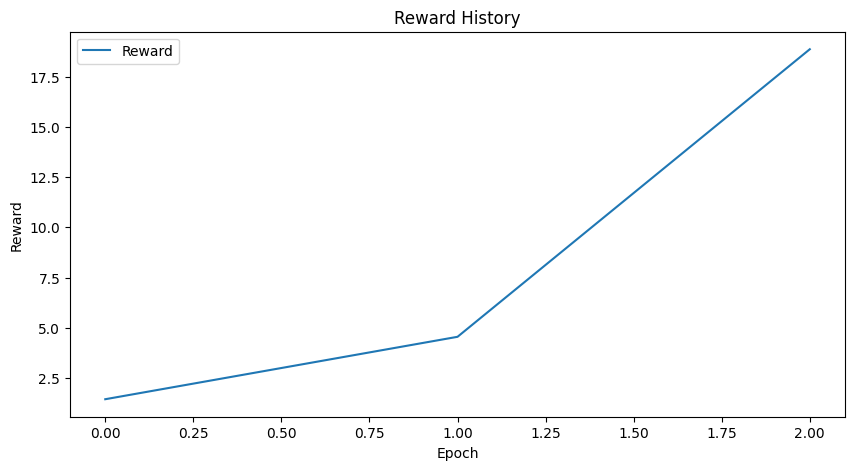

In [31]:
# Visualization
plt.figure(figsize=(10, 5))
plt.plot([reward.cpu().item() for reward in reward_history], label="Reward") # Moved tensors to CPU and extracted values
plt.xlabel("Epoch")
plt.ylabel("Reward")
plt.title("Reward History")
plt.legend()
plt.show()

In [22]:
# # Evaluation function
# def evaluate_model(actor, output_size, num_games=10):
#     rewards = []
#     for _ in range(num_games):
#         genom = torch.randn(output_size, device=device, requires_grad=True)
#         with torch.no_grad():
#             genom = actor(genom).cpu().numpy()
#         reward = check_genom(genom)
#         rewards.append(reward)
#     return np.mean(rewards), np.std(rewards)

# # Evaluate the model
# mean_reward, std_reward = evaluate_model(actor, env_dim)
# print(f"Mean Reward: {mean_reward:.2f}, Std Reward: {std_reward:.2f}")

Mean Reward: 10.01, Std Reward: 8.03
